# Effective Receptive Field

In [ ]:
%cd "../"

In [19]:
import timm
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

<center>
<img width="1000" src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*payapMR2TDuTk7H0mRdzqQ.png">
</center>

Prepare model

In [ ]:
model = timm.create_model('resnet50', pretrained=True).cuda()
preprocess_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
transform = timm.data.create_transform(**preprocess_cfg)
model.eval()

Prepare input

In [11]:
image = Image.open("samples/cats.jpg")
x = transform(image)
x = x.unsqueeze(0)
x = x.requires_grad_(True)

Feature extraction and gradient calculation

In [12]:
z = model.forward_features(x.cuda())
loss_vec = z[0, :, z.size(-2)//2, z.size(-1)//2]
loss = torch.sum(loss_vec)
loss.backward()

Visualization of most activated feature maps

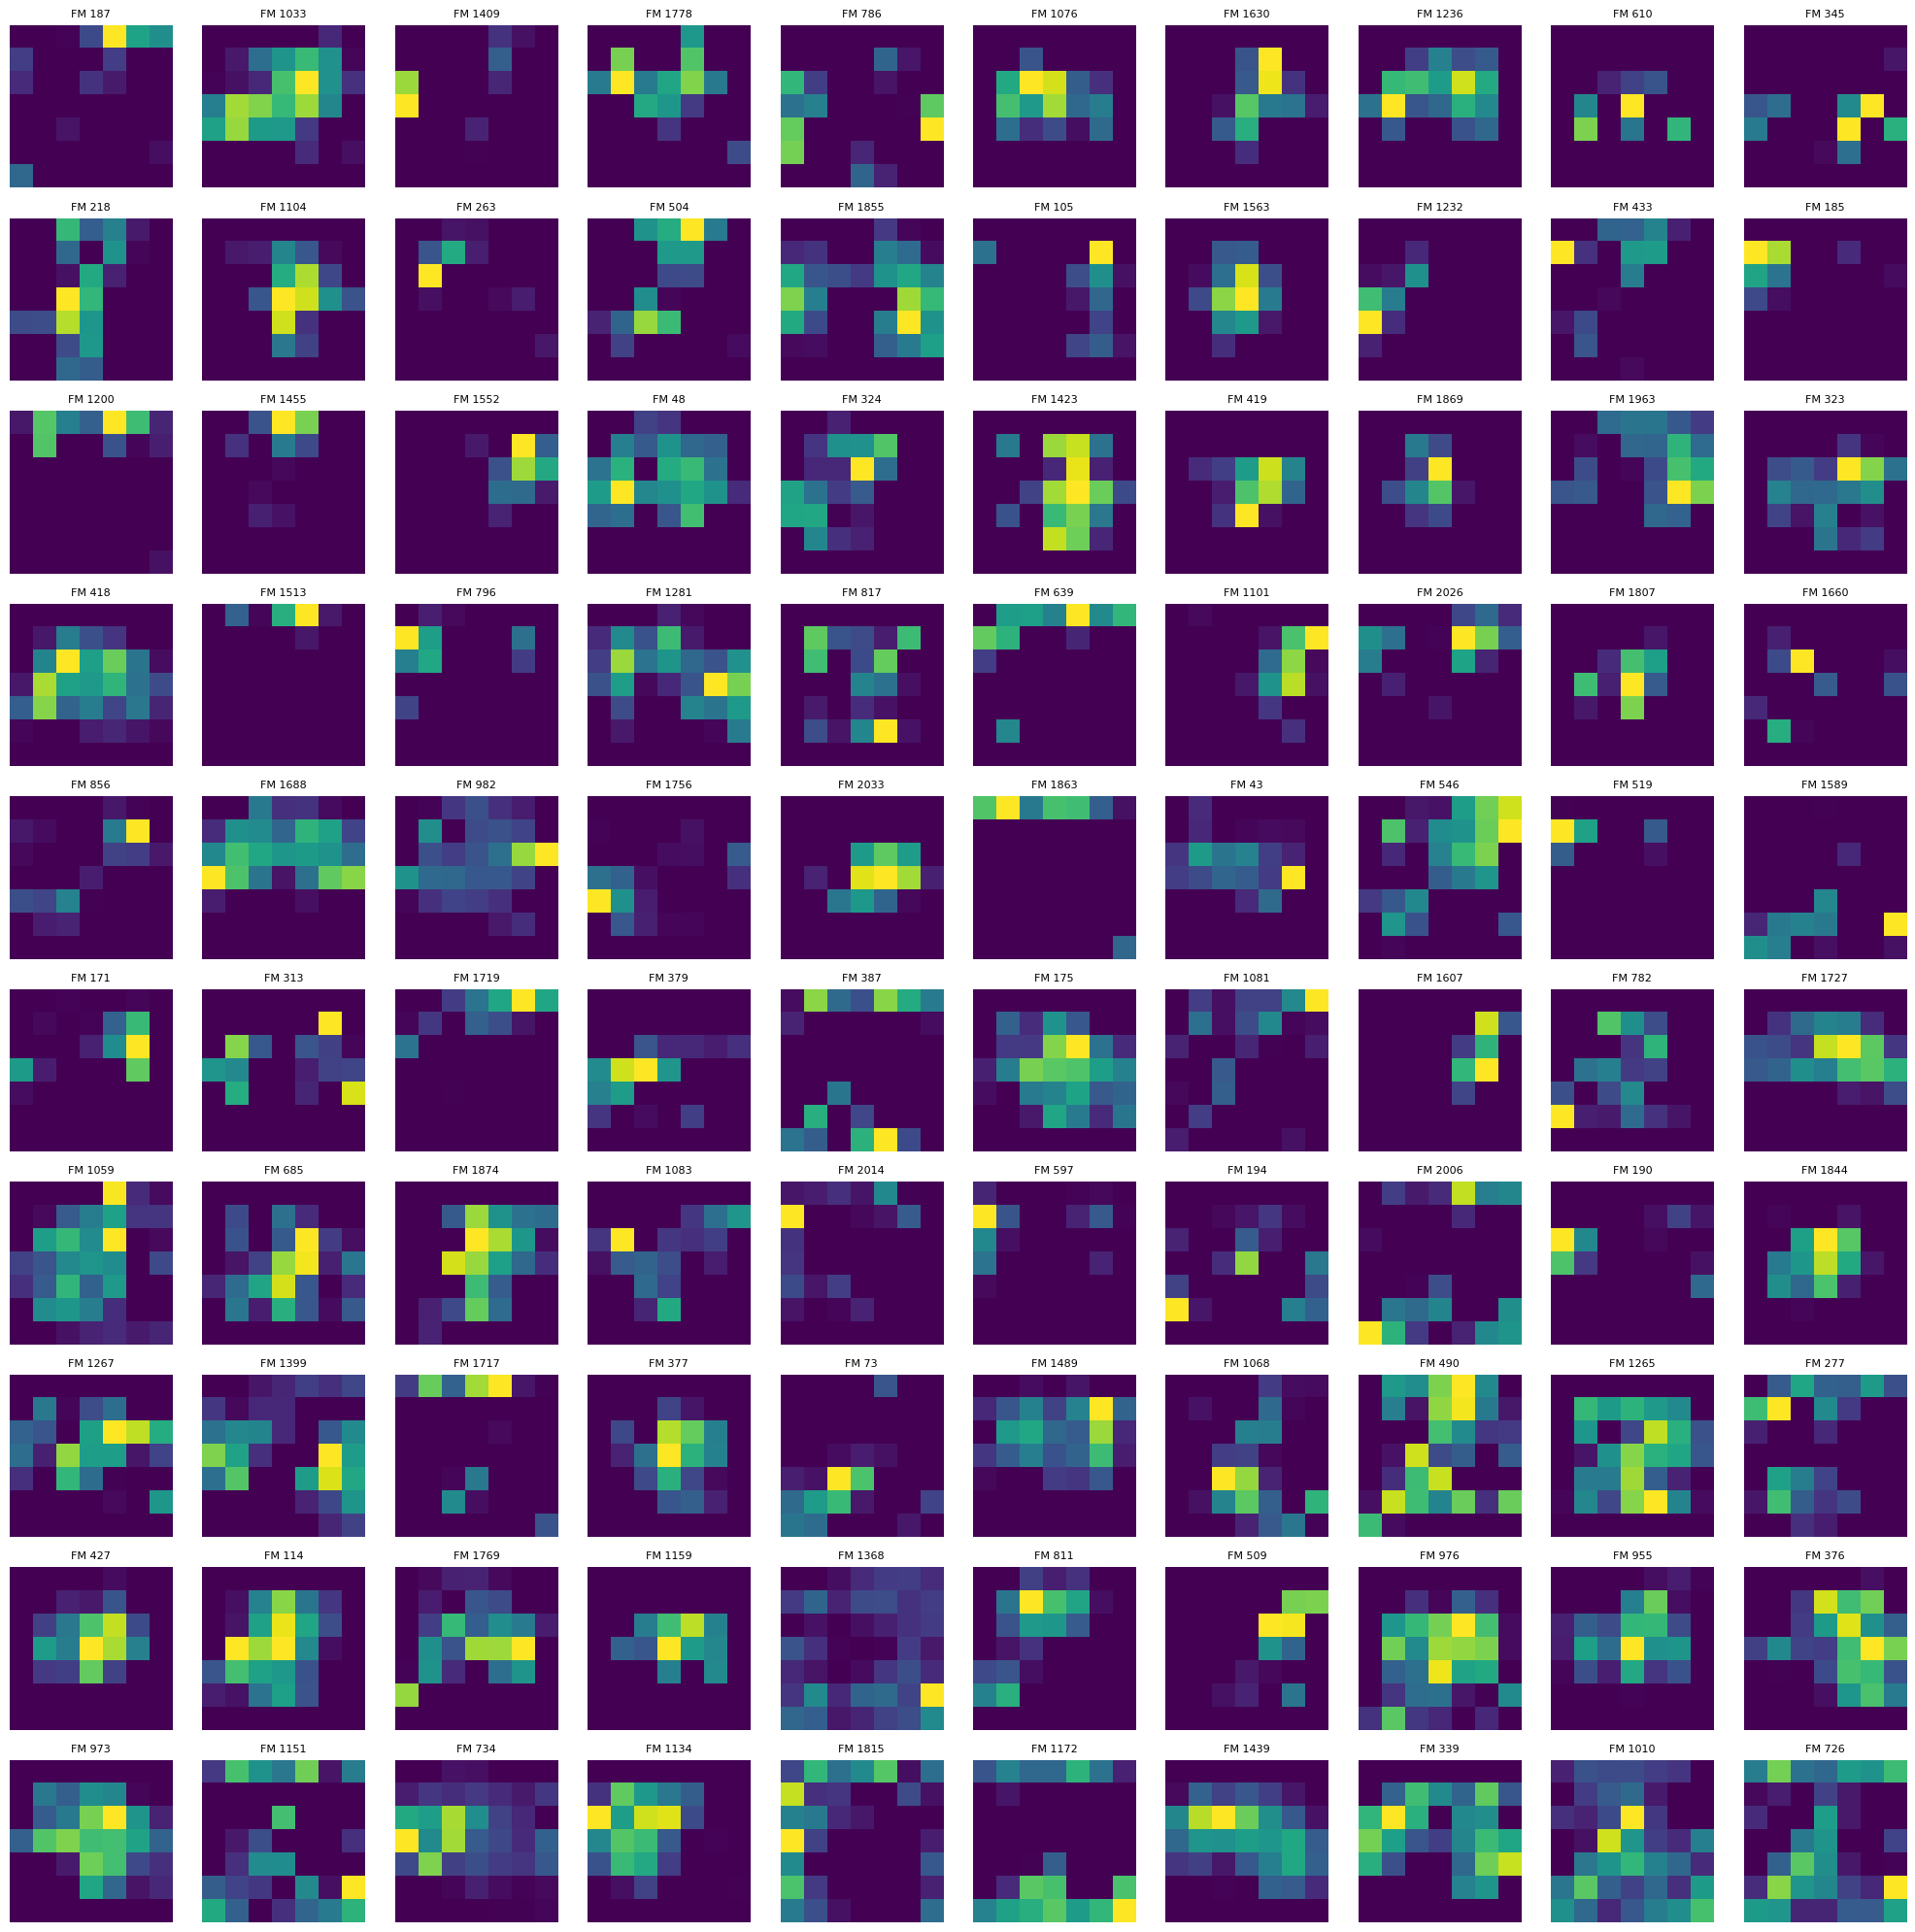

In [13]:
z_numpy = z.squeeze(0).detach().cpu().numpy()
mean_intensities = np.mean(z_numpy, axis=(1, 2))
top_100_indices = np.argsort(mean_intensities)[-100:]


fig, axes = plt.subplots(10, 10, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    feature_map_index = top_100_indices[i]
    ax.imshow(z_numpy[feature_map_index], cmap='viridis')
    ax.axis('off')
    ax.set_title(f'FM {feature_map_index}', fontsize=8)

plt.tight_layout()
plt.show()

Processing Gradient

In [15]:
gradients = torch.mean(x.grad[0], dim=0)
gradients = gradients.detach().cpu().numpy()

pos_grads = np.where(gradients >= 0, gradients, 0)
neg_grads = np.where(gradients < 0, gradients, 0)
neg_grads = np.abs(neg_grads)

min_val = np.min(pos_grads)
max_val = np.max(pos_grads)
pos_grads = (pos_grads - min_val) / (max_val - min_val)
pos_grads = pos_grads * 255

min_val = np.min(neg_grads)
max_val = np.max(neg_grads)
neg_grads = (neg_grads - min_val) / (max_val - min_val)
pos_grads = neg_grads * 255

pos_thres = np.max(pos_grads) * 0.1
neg_thres = np.max(neg_grads) * 0.1

pos_grads = np.where(pos_grads >= pos_thres, pos_grads, 0)
neg_grads = np.where(neg_grads >= neg_thres, neg_grads, 0)

Visualize the region in input $x$

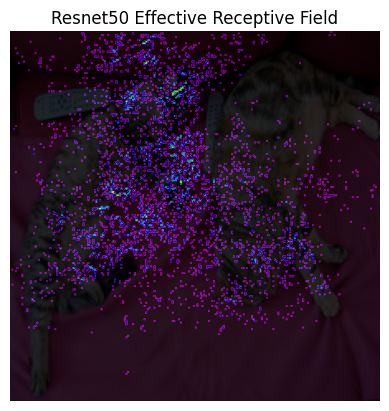

In [18]:
plt.imshow(np.array(image.resize((224, 224))))
plt.imshow(pos_grads, alpha=0.6, cmap='nipy_spectral')
plt.imshow(neg_grads, alpha=0.6, cmap='nipy_spectral')
plt.title("Resnet50 Effective Receptive Field")
plt.axis('off')
plt.show()